# PyTDMI (TDMI+Python ML/AI)

In [1]:
# Import interpretableML library LIME
from __future__ import print_function
# some_file.py
import sys
sys.path.insert(0, 'C:/Users/e351722/OneDrive - EDP/lime-master')
import lime
import lime.lime_tabular
# Import Libraries for data wrangling and machine learning 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Iterable
import itertools
import seaborn as sns
from sklearn.utils import indexable
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import random
from keras.models import Sequential
from sklearn.utils import shuffle
from keras.layers import Dense
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from graphviz import *
from copy import *
import datetime
from datetime import date, timedelta, datetime
from sklearn.metrics import r2_score, mean_squared_error,  mean_absolute_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import numpy as np
#%matplotlib inline 
## Run at end of script
#conn.close()

C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

# Fetch UNGE Data from TDMI & Holidays Locally

# Get Spain holidays from project folder

In [2]:
df0 = pd.read_excel('C:/Users/e351722/OneDrive - EDP/REN_prediction/holidays_ES.xlsx', sheet_name='Sheet1', converters={'Unnamed1':str, 
                                                                                        'Date':str,
                                                                                        'Weekday':str,
                                                                                        'Holiday':str,
                                                                                        'Holiday_type':str,
                                                                            
                                                                                        'Unnamed2':str})
df0 = df0.dropna()


df0['date'] = pd.DatetimeIndex(df0['Date'])
df0['dayofweek'] = df0['date'].apply(lambda x: x.dayofweek)
df0['dayofyear'] = df0['date'].apply(lambda x: x.dayofyear)


df0.tail()

,Date,Weekday,Holiday Name,Holiday Type,date,dayofweek,dayofyear
13,2019-12-08 00:00:00,Sunday,Immaculate Conception,National holiday,2019-12-08,6,342
14,2019-10-09 00:00:00,Monday,Immaculate Conception observed,National holiday,2019-10-09,2,282
15,2019-12-24 00:00:00,Tuesday,Christmas Eve,Observance,2019-12-24,1,358
16,2019-12-25 00:00:00,Wednesday,Christmas Day,National holiday,2019-12-25,2,359
17,2019-12-31 00:00:00,Tuesday,New Year's Eve,Observance,2019-12-31,1,365


# Fetch UNGE Data from TDMI 

In [3]:
# Import Oracle SQL Libraries
import cx_Oracle
import pandas as pd
import numpy as np

# SQL Connection Parameters
dsn = 'xdm2scan.cpdprd.pt:1521/EDP_PRD_TRD1'
conn = cx_Oracle.connect(user='saTDMIPTP03', password='DmoAcessoBD@0', dsn=dsn)
#print(conn)

# Define a parameter to access the cursor method. This parameter connects to the Oracle instance:
cursor = conn.cursor()

In [46]:
# Load Query file
fd = open('C:/Users/e351722/OneDrive - EDP/REN_prediction/Queries/Queries_PRECO_ES.sql', 'r')


sqlFile = fd.read()
fd.close()
sqlCommands = sqlFile.split(';')

In [5]:
# Get PRECO_ES, PRECO_PT, and ENERGY OMIE data
query = sqlCommands[0]
# Run Query
df1 = pd.read_sql(query, conn)
# Format dataframe
df1 = df1[['DATA', 'HORA', 'PRECO_ES', 'PRECO_PT', 'ENERGIA']].sort_values(by=['DATA', 'HORA']).reset_index(drop=True)
df1.columns = ['DATA', 'HORA', 'PRECO_ES', 'PRECO_PT', 'ENERGIA']
print(np.shape(df1))

lag = [48, 72, 96, 120, 144, 168, 192]
df_new = deepcopy(df1)
df_new = df_new.drop(['DATA', 'HORA'], axis=1)

for col in df_new.columns:
    for l in lag:
        df_new.loc[:,str(col)+'_'+str(l)] = df_new[col].shift(l)
        ## Rolling averages do not seem to improve the prediction, so I usually commented them out (next 2 lines)
        #datas=df_new[col].rolling(min_periods=1,window=7).mean()
        #df_new.loc[:,str(col)+'_mean_'+str(l)] = datas.reset_index(level=0, drop=True)
        
df_new = pd.concat([df1[['DATA','HORA']], df_new], axis = 1)
df1 = df_new
df1.tail()


(10272, 5)


,DATA,HORA,PRECO_ES,PRECO_PT,ENERGIA,PRECO_ES_48,PRECO_ES_72,PRECO_ES_96,PRECO_ES_120,PRECO_ES_144,...,PRECO_PT_144,PRECO_PT_168,PRECO_PT_192,ENERGIA_48,ENERGIA_72,ENERGIA_96,ENERGIA_120,ENERGIA_144,ENERGIA_168,ENERGIA_192
10267,2019-08-02,20,49.93,49.93,29535.4,48.79,49.18,47.23,46.42,41.05,...,41.05,53.62,58.37,28290.6,29606.2,30089.7,23035.9,25393.0,31985.95,33348.90
10268,2019-08-02,21,50.70,50.70,29009.0,48.17,50.01,46.07,53.59,42.82,...,42.82,52.06,58.52,27683.2,28836.7,29323.5,23205.1,25295.4,31331.20,32653.10
10269,2019-08-02,22,50.87,50.87,28859.1,48.79,50.85,46.99,57.05,45.78,...,45.78,51.80,56.75,27495.6,28504.1,28911.2,23613.2,25387.7,30527.00,31234.85
10270,2019-08-02,23,49.92,49.92,27817.1,50.17,51.42,49.38,58.25,49.49,...,49.49,56.06,55.50,27480.3,28471.9,28880.1,24532.0,25212.4,29108.50,30792.90
10271,2019-08-02,24,48.00,48.00,25898.5,45.19,47.00,44.64,55.09,44.94,...,44.94,52.77,49.41,25182.6,25514.5,26031.1,22606.3,23719.4,26732.40,28459.90


In [6]:
# Get Wind_ES data
query = sqlCommands[1]
# Run Query
df2 = pd.read_sql(query, conn)
# Format dataframe
df2 = df2[['MARKET_DATE', 'MARKET_HOUR', 'VALUE']].sort_values(by=['MARKET_DATE', 'MARKET_HOUR']).reset_index(drop=True)
df2.columns = ['DATA', 'HORA', 'Wind_ES']
df2.tail()

,DATA,HORA,Wind_ES
10581,2019-08-15,22,8081.735
10582,2019-08-15,23,8019.811
10583,2019-08-15,24,7927.444
10584,2019-08-16,1,7794.764
10585,2019-08-16,2,7639.481


In [7]:
# Get REE_DEMAND_ES data
query = sqlCommands[2]
# Run Query
df3 = pd.read_sql(query, conn)
# Format dataframe
df3 = df3[['MARKET_DATE', 'MARKET_HOUR', 'VALUE']].sort_values(by=['MARKET_DATE', 'MARKET_HOUR']).reset_index(drop=True)
df3.columns = ['DATA', 'HORA', 'REE_DEMAND_ES']
df3.tail()

,DATA,HORA,REE_DEMAND_ES
10243,2019-08-09,20,31994
10244,2019-08-09,21,31292
10245,2019-08-09,22,31362
10246,2019-08-09,23,30674
10247,2019-08-09,24,28861


In [8]:
# Get PRECO_FR data
query = sqlCommands[3]
# Run Query
df4 = pd.read_sql(query, conn)
# Format dataframe
df4 = df4[['MARKET_DATE', 'MARKET_HOUR', 'VALUE']].sort_values(by=['MARKET_DATE', 'MARKET_HOUR']).reset_index(drop=True)
df4.columns = ['DATA', 'HORA', 'PRECO_FR']
df4.tail(5)


,DATA,HORA,PRECO_FR
10582,2019-08-15,23,42.2
10583,2019-08-15,24,39.5
10584,2019-08-16,1,35.7
10585,2019-08-16,2,32.6
10586,2019-08-16,3,31.0


In [9]:
# Get Solar_ES data
query = sqlCommands[4]
# Run Query
df5 = pd.read_sql(query, conn)
# Format dataframe
df5 = df5[['MARKET_DATE', 'MARKET_HOUR', 'QUANTITY']].sort_values(by=['MARKET_DATE', 'MARKET_HOUR']).reset_index(drop=True)
df5.columns = ['DATA', 'HORA', 'Solar_ES']
df5.tail(5)


,DATA,HORA,Solar_ES
9944,2019-07-20,10,1630.0
9945,2019-07-20,11,2318.0
9946,2019-07-20,12,2778.0
9947,2019-07-20,13,3089.0
9948,2019-07-20,14,3267.0


In [10]:
# Get METEO_DEMAND_PT data
query = sqlCommands[5]
# Run Query
df6 = pd.read_sql(query, conn)
# Format dataframe
df6 = df6[['MARKET_DATE', 'MARKET_HOUR', 'VALUE']].sort_values(by=['MARKET_DATE', 'MARKET_HOUR']).reset_index(drop=True)
df6.columns = ['DATA', 'HORA', 'METEO_DEMAND_PT']
df6.tail(5)


,DATA,HORA,METEO_DEMAND_PT
10436,2019-08-09,21,20.944088
10437,2019-08-09,22,25.181830
10438,2019-08-09,23,23.975260
10439,2019-08-09,24,16.636748
10440,2019-08-10,1,10.488817


In [11]:
# Get ENTSOE data
query = sqlCommands[6]
# Run Query
df7 = pd.read_sql(query, conn)
df7 = df7[(df7['TYPE']=='Ask Price') | (df7['TYPE']== 'Mercado Diario' )]
df7 = df7[['DATA', 'UNIT', 'VALUE']].sort_values(by=['DATA']).reset_index(drop=True)
df7.tail()

,DATA,UNIT,VALUE
20270,2019-08-02,Precos de Energia Mercado Diario ? Portugal - ...,48.853333
20271,2019-08-02,ENTSOE: Day Ahead Prices - Espanha (Espanha) -...,48.853333
20272,2019-08-02,Precos de electricidade Mercado Diario ? Franc...,41.309167
20273,2019-08-02,Precos de electricidade Mercado Diario - UK - ...,41.669167
20274,2019-08-02,Precos de Energia Mercado Diario ? Franca - EU...,41.309167


In [12]:
# Format dataframe
newdf = pd.pivot_table(df7, index=['DATA'], columns = 'UNIT')
newdf = newdf.reset_index()
dfmerged = pd.merge(df1[['DATA','HORA']], newdf, how='left', on = ['DATA'])
df7 = dfmerged.reset_index(drop=True)
df7.head()

C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,DATA,HORA,"(VALUE, ENTSOE: Day Ahead Prices - Alemanha (Alemanha - Austria - Luxemburgo) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Alemanha (Alemanha - Luxemburgo) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Austria (Alemanha - Austria - Luxemburgo) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Austria (Austria) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Belgica (Belgica) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-1) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-2) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Eslovenia (Eslovenia) - EUR/MWH)",...,"(VALUE, Precos de electricidade Mercado Diario Polpex - Reuters - PLN/MWh)","(VALUE, Precos de eletricidade Mercado Diario ? Alemanha (EEX Phelix) - Reuters - EUR/MWh)","(VALUE, Taxa de Cambio EUR / AOA - Reuters - 1EUR=xAOA)","(VALUE, Taxa de Cambio EUR / GBP - Reuters - 1EUR=xGBP)","(VALUE, Taxa de Cambio EUR / MAD - Reuters - 1EUR=xMAD)","(VALUE, Taxa de Cambio EUR / MOP - Reuters - 1EUR=xMOP)","(VALUE, Taxa de Cambio EUR / USD - Reuters - 1EUR=xUSD)","(VALUE, Taxa de Cambio EUR / XAF - Reuters - 1EUR=xXAF)","(VALUE, Taxa de Cambio USD / EUR - Reuters - 1USD=xEUR)","(VALUE, Taxa de Juros WIBOR Overnight PLN - Percentage)"
0,2018-06-01,1,51.297917,NaN,51.297917,NaN,66.600417,53.89375,56.259167,57.165833,...,238.215417,51.297917,279.05,0.8744,11.0845,9.4326,1.1661,690.0,0.8576,1.58
1,2018-06-01,2,51.297917,NaN,51.297917,NaN,66.600417,53.89375,56.259167,57.165833,...,238.215417,51.297917,279.05,0.8744,11.0845,9.4326,1.1661,690.0,0.8576,1.58
2,2018-06-01,3,51.297917,NaN,51.297917,NaN,66.600417,53.89375,56.259167,57.165833,...,238.215417,51.297917,279.05,0.8744,11.0845,9.4326,1.1661,690.0,0.8576,1.58
3,2018-06-01,4,51.297917,NaN,51.297917,NaN,66.600417,53.89375,56.259167,57.165833,...,238.215417,51.297917,279.05,0.8744,11.0845,9.4326,1.1661,690.0,0.8576,1.58
4,2018-06-01,5,51.297917,NaN,51.297917,NaN,66.600417,53.89375,56.259167,57.165833,...,238.215417,51.297917,279.05,0.8744,11.0845,9.4326,1.1661,690.0,0.8576,1.58


In [13]:
df7.tail(24)

,DATA,HORA,"(VALUE, ENTSOE: Day Ahead Prices - Alemanha (Alemanha - Austria - Luxemburgo) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Alemanha (Alemanha - Luxemburgo) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Austria (Alemanha - Austria - Luxemburgo) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Austria (Austria) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Belgica (Belgica) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-1) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-2) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Eslovenia (Eslovenia) - EUR/MWH)",...,"(VALUE, Precos de electricidade Mercado Diario Polpex - Reuters - PLN/MWh)","(VALUE, Precos de eletricidade Mercado Diario ? Alemanha (EEX Phelix) - Reuters - EUR/MWh)","(VALUE, Taxa de Cambio EUR / AOA - Reuters - 1EUR=xAOA)","(VALUE, Taxa de Cambio EUR / GBP - Reuters - 1EUR=xGBP)","(VALUE, Taxa de Cambio EUR / MAD - Reuters - 1EUR=xMAD)","(VALUE, Taxa de Cambio EUR / MOP - Reuters - 1EUR=xMOP)","(VALUE, Taxa de Cambio EUR / USD - Reuters - 1EUR=xUSD)","(VALUE, Taxa de Cambio EUR / XAF - Reuters - 1EUR=xXAF)","(VALUE, Taxa de Cambio USD / EUR - Reuters - 1USD=xEUR)","(VALUE, Taxa de Juros WIBOR Overnight PLN - Percentage)"
10248,2019-08-02,1,NaN,43.699583,NaN,44.019583,41.251667,43.70125,43.70125,45.6175,...,271.480417,43.699583,NaN,0.9154,NaN,NaN,1.1099,NaN,NaN,NaN
10249,2019-08-02,2,NaN,43.699583,NaN,44.019583,41.251667,43.70125,43.70125,45.6175,...,271.480417,43.699583,NaN,0.9154,NaN,NaN,1.1099,NaN,NaN,NaN
10250,2019-08-02,3,NaN,43.699583,NaN,44.019583,41.251667,43.70125,43.70125,45.6175,...,271.480417,43.699583,NaN,0.9154,NaN,NaN,1.1099,NaN,NaN,NaN
10251,2019-08-02,4,NaN,43.699583,NaN,44.019583,41.251667,43.70125,43.70125,45.6175,...,271.480417,43.699583,NaN,0.9154,NaN,NaN,1.1099,NaN,NaN,NaN
10252,2019-08-02,5,NaN,43.699583,NaN,44.019583,41.251667,43.70125,43.70125,45.6175,...,271.480417,43.699583,NaN,0.9154,NaN,NaN,1.1099,NaN,NaN,NaN
10253,2019-08-02,6,NaN,43.699583,NaN,44.019583,41.251667,43.70125,43.70125,45.6175,...,271.480417,43.699583,NaN,0.9154,NaN,NaN,1.1099,NaN,NaN,NaN
10254,2019-08-02,7,NaN,43.699583,NaN,44.019583,41.251667,43.70125,43.70125,45.6175,...,271.480417,43.699583,NaN,0.9154,NaN,NaN,1.1099,NaN,NaN,NaN
10255,2019-08-02,8,NaN,43.699583,NaN,44.019583,41.251667,43.70125,43.70125,45.6175,...,271.480417,43.699583,NaN,0.9154,NaN,NaN,1.1099,NaN,NaN,NaN
10256,2019-08-02,9,NaN,43.699583,NaN,44.019583,41.251667,43.70125,43.70125,45.6175,...,271.480417,43.699583,NaN,0.9154,NaN,NaN,1.1099,NaN,NaN,NaN
10257,2019-08-02,10,NaN,43.699583,NaN,44.019583,41.251667,43.70125,43.70125,45.6175,...,271.480417,43.699583,NaN,0.9154,NaN,NaN,1.1099,NaN,NaN,NaN


In [14]:
df7a = df7[df7[df7.DATA == max(df7.DATA)].dropna(axis=1).columns]

dropcols = df7[df7[df7.DATA == max(df7.DATA)].dropna(axis=1).columns.drop(['DATA','HORA'])].columns
df7 = df7.drop(columns = dropcols)
df7a.tail()

,DATA,HORA,"(VALUE, ENTSOE: Day Ahead Prices - Alemanha (Alemanha - Luxemburgo) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Austria (Austria) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Belgica (Belgica) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-1) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-2) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Eslovenia (Eslovenia) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Espanha (Espanha) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Franca (Franca) - EUR/MWH)",...,"(VALUE, Precos de Energia Mercado Diario Nordpool N2EX - GBP/MWh)","(VALUE, Precos de electricidade Mercado Diario - IT - Reuters - EUR/MWh)","(VALUE, Precos de electricidade Mercado Diario - UK - Reuters - GBP/MWh)","(VALUE, Precos de electricidade Mercado Diario ? Franca (EPEX) - Reuters - EUR/MWh)","(VALUE, Precos de electricidade Mercado Diario APX para HUB NL - Reuters - EUR/MWh)","(VALUE, Precos de electricidade Mercado Diario Belpex - Reuters - EUR/MWh)","(VALUE, Precos de electricidade Mercado Diario Polpex - Reuters - PLN/MWh)","(VALUE, Precos de eletricidade Mercado Diario ? Alemanha (EEX Phelix) - Reuters - EUR/MWh)","(VALUE, Taxa de Cambio EUR / GBP - Reuters - 1EUR=xGBP)","(VALUE, Taxa de Cambio EUR / USD - Reuters - 1EUR=xUSD)"
10267,2019-08-02,20,43.699583,44.019583,41.251667,43.70125,43.70125,45.6175,48.853333,41.309167,...,41.669167,47.569419,41.669167,41.309167,42.640417,41.251667,271.480417,43.699583,0.9154,1.1099
10268,2019-08-02,21,43.699583,44.019583,41.251667,43.70125,43.70125,45.6175,48.853333,41.309167,...,41.669167,47.569419,41.669167,41.309167,42.640417,41.251667,271.480417,43.699583,0.9154,1.1099
10269,2019-08-02,22,43.699583,44.019583,41.251667,43.70125,43.70125,45.6175,48.853333,41.309167,...,41.669167,47.569419,41.669167,41.309167,42.640417,41.251667,271.480417,43.699583,0.9154,1.1099
10270,2019-08-02,23,43.699583,44.019583,41.251667,43.70125,43.70125,45.6175,48.853333,41.309167,...,41.669167,47.569419,41.669167,41.309167,42.640417,41.251667,271.480417,43.699583,0.9154,1.1099
10271,2019-08-02,24,43.699583,44.019583,41.251667,43.70125,43.70125,45.6175,48.853333,41.309167,...,41.669167,47.569419,41.669167,41.309167,42.640417,41.251667,271.480417,43.699583,0.9154,1.1099


In [15]:
# Get OTC data
query = sqlCommands[7]
# Run Query
df8 = pd.read_sql(query, conn)
df8.columns = ['FWD', 'PERIOD', 'DATA', 'OTC_VALUE']
df8 = df8.sort_values(by=['DATA']).reset_index(drop=True)

# Format dataframe
newdf = pd.pivot_table(df8, index=['DATA'], columns = ['FWD', 'PERIOD'])
newdf = newdf.reset_index()
dfmerged = pd.merge(df1[['DATA','HORA']], newdf, how='left', on = ['DATA'])
df8 = dfmerged.reset_index(drop=True)

lag = [24*1]
df_new = deepcopy(df8)
df_new = df_new.drop(['DATA', 'HORA'], axis=1)

for col in df_new.columns:
    for l in lag:
        df_new.loc[:,str(col)+'_'+str(l)] = df_new[col].shift(l)
        ## Rolling averages do not seem to improve the prediction, so I usually commented them out (next 2 lines)
        #datas=df_new[col].rolling(min_periods=1,window=7).mean()
        #df_new.loc[:,str(col)+'_mean_'+str(l)] = datas.reset_index(level=0, drop=True)
        
df_new = pd.concat([df8[['DATA','HORA']], df_new], axis = 1)
df8 = df_new


df8a = df8[df8[df8.DATA == max(df8.DATA)].dropna(axis=1).columns]

dropcols = df8[df8[df8.DATA == max(df8.DATA)].dropna(axis=1).columns.drop(['DATA','HORA'])].columns
df8 = df8.drop(columns = dropcols)
df8a.tail()

C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 3 on the right)
  warnings.warn(msg, UserWarning)


,DATA,HORA,"('OTC_VALUE', 'Preco Mercado OTC Baseload - Espanha', 'M')_24","('OTC_VALUE', 'Preco Mercado OTC Baseload - Espanha', 'Q')_24","('OTC_VALUE', 'Preco Mercado OTC Baseload - Espanha', 'Y')_24","('OTC_VALUE', 'Preco Mercado OTC Baseload ? Alemanha', 'M')_24","('OTC_VALUE', 'Preco Mercado OTC Baseload ? Alemanha', 'Q')_24","('OTC_VALUE', 'Preco Mercado OTC Baseload ? Alemanha', 'Y')_24","('OTC_VALUE', 'Preco Mercado OTC Baseload ? Franca', 'M')_24","('OTC_VALUE', 'Preco Mercado OTC Baseload ? Franca', 'Q')_24","('OTC_VALUE', 'Preco Mercado OTC Baseload ? Franca', 'Y')_24","('OTC_VALUE', 'Preco Mercado OTC Peakload ? Franca', 'M')_24","('OTC_VALUE', 'Preco Mercado OTC Peakload ? Franca', 'Q')_24","('OTC_VALUE', 'Preco Mercado OTC Peakload ? Franca', 'Y')_24"
10267,2019-08-02,20,54.628571,54.983333,55.15,50.96125,51.173077,51.85,49.705878,49.87,49.9625,63.166,63.829231,64.25
10268,2019-08-02,21,54.628571,54.983333,55.15,50.96125,51.173077,51.85,49.705878,49.87,49.9625,63.166,63.829231,64.25
10269,2019-08-02,22,54.628571,54.983333,55.15,50.96125,51.173077,51.85,49.705878,49.87,49.9625,63.166,63.829231,64.25
10270,2019-08-02,23,54.628571,54.983333,55.15,50.96125,51.173077,51.85,49.705878,49.87,49.9625,63.166,63.829231,64.25
10271,2019-08-02,24,54.628571,54.983333,55.15,50.96125,51.173077,51.85,49.705878,49.87,49.9625,63.166,63.829231,64.25


In [16]:
# Get PBC data
query = sqlCommands[8]
# Run Query
df9 = pd.read_sql(query, conn)
# Format dataframe
df9 = df9[['DATA', 'HORA', 'TIPO_OFERTA', 'PRECO_PBC', 'ENERGY_PBC']].sort_values(by=['DATA', 'HORA']).reset_index(drop=True)
# Pivot dataframe
newdf = pd.pivot_table(df9, index=['DATA','HORA'], columns = ['TIPO_OFERTA'])
newdf = newdf.reset_index()
dfmerged = pd.merge(df1[['DATA','HORA']], newdf, how='left', on = ['DATA', 'HORA'])
df9 = dfmerged.reset_index(drop=True)
df9.tail(50)

C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,DATA,HORA,"(ENERGY_PBC, C)","(ENERGY_PBC, V)","(PRECO_PBC, C)","(PRECO_PBC, V)"
10222,2019-07-31,23,66.540995,34.624291,98.118175,8.670986
10223,2019-07-31,24,60.239720,33.353946,96.831215,6.882109
10224,2019-08-01,1,57.345694,31.211589,99.550048,7.793529
10225,2019-08-01,2,52.125653,30.144093,97.942423,6.058063
10226,2019-08-01,3,48.288631,29.396045,97.164571,4.887571
10227,2019-08-01,4,46.562645,28.669286,96.669188,4.629171
10228,2019-08-01,5,45.646759,28.050356,96.261736,4.860142
10229,2019-08-01,6,47.373747,27.568889,98.408926,5.583861
10230,2019-08-01,7,47.847556,28.746862,95.492133,5.999506
10231,2019-08-01,8,52.215232,28.125446,96.464062,6.877396


In [17]:
# Get Hydro PT data
query = sqlCommands[9]
# Run Query
df10 = pd.read_sql(query, conn)
# Format dataframe
df10 = df10[['MARKET_DATE', 'MARKET_HOUR', 'VALUE']].sort_values(by=['MARKET_DATE', 'MARKET_HOUR']).reset_index(drop=True)
df10.columns = ['DATA', 'HORA', 'Hydro_PT']
df10.tail(5)


,DATA,HORA,Hydro_PT
10594,2019-08-16,11,5426.763
10595,2019-08-16,12,5585.921
10596,2019-08-16,13,5749.605
10597,2019-08-16,14,5678.287
10598,2019-08-16,15,5668.276


In [18]:
# Load Competition Data
df11 = pd.read_pickle('C:/Users/e351722/OneDrive - EDP/lime-master/REN_prediction/competition.pkl')
df11 = df11[['DATA', 'HORA', 'TOTAL_COMPRAS_PT', 'TOTAL_VENTAS_PT', 'COMPETITION_COMPRAS', 'COMPETITION_VENTAS']]
df11.tail()

,DATA,HORA,TOTAL_COMPRAS_PT,TOTAL_VENTAS_PT,COMPETITION_COMPRAS,COMPETITION_VENTAS
11731,2019-08-02,20,6150.9,6298.2,3375.4,1868.1
11732,2019-08-02,21,6212.2,6758.4,3332.4,1921.1
11733,2019-08-02,22,6243.2,6839.7,3279.2,1914.9
11734,2019-08-02,23,6299.9,6289.8,3221.4,1734.4
11735,2019-08-02,24,5966.5,5307.3,3033.9,1203.1


In [19]:
# Get Temperature PT data
query = sqlCommands[10]
# Run Query
df12 = pd.read_sql(query, conn)
df12.columns = ['DATA', 'HORA', 'Zone', 'Temperature']
df12.DATA =  pd.DatetimeIndex(df12['DATA'])
df12.HORA = df12.HORA.astype('int')
df12.Temperature = df12.Temperature.astype('float32')
newdf = pd.pivot_table(df12, index=['DATA', 'HORA'], columns = 'Zone')
newdf = newdf.reset_index()
newdf.tail(24)
df12=newdf

lag = [-1]
df_new = deepcopy(df12)
df_new = df_new.drop(['DATA', 'HORA'], axis=1)

for col in df_new.columns:
    for l in lag:
        df_new.loc[:,str(col)+'_'+str(l)] = df_new[col].shift(l)
        ## Rolling averages do not seem to improve the prediction, so I usually commented them out (next 2 lines)
        #datas=df_new[col].rolling(min_periods=1,window=7).mean()
        #df_new.loc[:,str(col)+'_mean_'+str(l)] = datas.reset_index(level=0, drop=True)
        
df_new = pd.concat([df12[['DATA','HORA']], df_new], axis = 1)
df12 = df_new



df12.tail()

C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


DATA HORA Temperature                                              \
Zone                        Braga    Coimbra       Faro     Leiria     Lisboa   
10444 2019-08-10   13   21.400000  21.700001  26.100000  21.100000  23.500000   
10445 2019-08-10   14   22.500000  23.400000  27.299999  22.100000  24.500000   
10446 2019-08-10   15   23.700001  25.100000  28.400000  23.100000  25.799999   
10447 2019-08-10   16   24.200001  25.299999  28.900000  23.200001  26.200001   
10448 2019-08-10   17   24.799999  25.600000  29.000000  23.400000  26.600000   

                 ('Temperature', 'Braga')_-1 ('Temperature', 'Coimbra')_-1  \
Zone       Porto                                                             
10444  18.500000                   22.500000                     23.400000   
10445  19.200001                   23.700001                     25.100000   
10446  20.200001                   24.200001                     25.299999   
10447  20.600000                   24.799999                     25.600000   
10448  20.799999                         NaN                           NaN   

      ('Temperature', 'Faro')_-1 ('Temperature', 'Leiria')_-1  \
Zone                                                            
10444                  27.299999                    22.100000   
10445                  28.400000                    23.100000   
10446                  28.900000                    23.200001   
10447                  29.000000                    23.400000   
10448                        NaN                          NaN   

      ('Temperature', 'Lisboa')_-1 ('Temperature', 'Porto')_-1  
Zone                                                            
10444                    24.500000                   19.200001  
10445                    25.799999                   20.200001  
10446                    26.200001                   20.600000  
10447                    26.600000                   20.799999  
10448                          NaN                         NaN

In [54]:
# Get Interligacao data
query = sqlCommands[11]
# Run Query
df13 = pd.read_sql(query, conn)
df13.columns = ['DATA', 'HORA', 'Border', 'Capacity']
df13.DATA =  pd.DatetimeIndex(df13['DATA'])
df13.HORA = df13.HORA.astype('int')
df13.Capacity = df13.Capacity.astype('float32')
newdf = pd.pivot_table(df13, index=['DATA', 'HORA'], columns = 'Border')
newdf = newdf.reset_index()
newdf.tail(24)
df13=newdf

lag = [-1]
df_new = deepcopy(df13)
df_new = df_new.drop(['DATA', 'HORA'], axis=1)

for col in df_new.columns:
    for l in lag:
        df_new.loc[:,str(col)+'_'+str(l)] = df_new[col].shift(l)
        ## Rolling averages do not seem to improve the prediction, so I usually commented them out (next 2 lines)
        #datas=df_new[col].rolling(min_periods=1,window=7).mean()
        #df_new.loc[:,str(col)+'_mean_'+str(l)] = datas.reset_index(level=0, drop=True)
        
df_new = pd.concat([df13[['DATA','HORA']], df_new], axis = 1)
df13 = df_new



df13.tail()

DATA HORA Capacity                                               \
Border                 AN -> ES ES -> AN ES -> FR ES -> MA ES -> PT FR -> ES   
12018  2020-07-31   17    107.0    107.0   2050.0    900.0   2430.0   2900.0   
12019  2020-07-31   18    107.0    107.0   2050.0    900.0   2430.0   2900.0   
12020  2020-07-31   19    107.0    107.0   2050.0    900.0   2430.0   2900.0   
12021  2020-07-31   20    107.0    107.0   2050.0    900.0   2430.0   2900.0   
12022  2020-07-31   21    107.0    107.0   2050.0    900.0   2430.0   2900.0   

                         ('Capacity', 'AN -> ES')_-1  \
Border MA -> ES PT -> ES                               
12018     600.0   2500.0                       107.0   
12019     600.0   2500.0                       107.0   
12020     600.0   2500.0                       107.0   
12021     600.0   2500.0                       107.0   
12022     600.0   2500.0                         NaN   

       ('Capacity', 'ES -> AN')_-1 ('Capacity', 'ES -> FR')_-1  \
Border                                                           
12018                        107.0                      2050.0   
12019                        107.0                      2050.0   
12020                        107.0                      2050.0   
12021                        107.0                      2050.0   
12022                          NaN                         NaN   

       ('Capacity', 'ES -> MA')_-1 ('Capacity', 'ES -> PT')_-1  \
Border                                                           
12018                        900.0                      2430.0   
12019                        900.0                      2430.0   
12020                        900.0                      2430.0   
12021                        900.0                      2430.0   
12022                          NaN                         NaN   

       ('Capacity', 'FR -> ES')_-1 ('Capacity', 'MA -> ES')_-1  \
Border                                                           
12018                       2900.0                       600.0   
12019                       2900.0                       600.0   
12020                       2900.0                       600.0   
12021                       2900.0                       600.0   
12022                          NaN                         NaN   

       ('Capacity', 'PT -> ES')_-1  
Border                              
12018                       2500.0  
12019                       2500.0  
12020                       2500.0  
12021                       2500.0  
12022                          NaN

In [56]:
# Get SOL_REE data
query = sqlCommands[12]
# Run Query
df14 = pd.read_sql(query, conn)
df14.columns = ['DATA', 'HORA', 'Sol_REE']
# Format dataframe
df14 = df14[['DATA', 'HORA', 'Sol_REE']].sort_values(by=['DATA', 'HORA']).reset_index(drop=True)
df14.tail(5)


,DATA,HORA,Sol_REE
9450,2019-08-03,20,3142.5
9451,2019-08-03,21,1703.5
9452,2019-08-03,22,811.9
9453,2019-08-03,23,576.4
9454,2019-08-03,24,549.5


In [50]:
# Get Bids PT data
query = sqlCommands[13]
# Run Query
df15 = pd.read_sql(query, conn)
df15.columns = ['DATA', 'HORA', 'UNIT', 'Q','P']
df15.DATA =  pd.DatetimeIndex(df15['DATA'])
df15.HORA = df15.HORA.astype('int')
df15.Q = df15.Q.astype('float32')
df15.P = df15.P.astype('float32')

newdf = pd.pivot_table(df15, index=['DATA', 'HORA'], columns = 'UNIT')
newdf = newdf.reset_index()
newdf.tail(24)
df15=newdf

lag = [-1]
df_new = deepcopy(df15)
df_new = df_new.drop(['DATA', 'HORA'], axis=1)

for col in df_new.columns:
    for l in lag:
        df_new.loc[:,str(col)+'_'+str(l)] = df_new[col].shift(l)
        ## Rolling averages do not seem to improve the prediction, so I usually commented them out (next 2 lines)
        #datas=df_new[col].rolling(min_periods=1,window=7).mean()
        #df_new.loc[:,str(col)+'_mean_'+str(l)] = datas.reset_index(level=0, drop=True)
        
df_new = pd.concat([df15[['DATA','HORA']], df_new], axis = 1)

newdf = newdf.drop(columns=[('P', '00000'), ('Q', '00000')], axis=1) 
df15=newdf


df15.tail()

AttributeError: 'DataFrame' object has no attribute 'Capacity'

In [57]:
df15

DATA HORA           P                                              \
UNIT                         ABO1       ABO2    ACAVADB    ACAVADO     ADOURO   
0     2018-06-01    1   68.346664  70.226669  29.485001  78.416313  63.194447   
1     2018-06-01    2   68.846664  70.226669  29.485001  78.416313  63.194447   
2     2018-06-01    3   68.846664  70.226669  29.485001  78.416313  63.194447   
3     2018-06-01    4   68.846664  70.226669  29.485001  78.416313  63.194447   
4     2018-06-01    5   68.846664  70.226669  29.485001  78.416313  63.194447   
5     2018-06-01    6   68.846664  70.226669  29.485001  78.416313  63.194447   
6     2018-06-01    7   68.846664  70.226669  29.485001  78.416313  63.194447   
7     2018-06-01    8   69.180000  70.226669  29.485001  78.416313  63.194447   
8     2018-06-01    9   69.046669  71.393333  29.485001  78.416313  63.194447   
9     2018-06-01   10   69.879997  71.393333  29.485001  78.416313  63.194447   
10    2018-06-01   11   69.879997  71.393333  29.485001  78.416313  63.194447   
11    2018-06-01   12   69.879997  71.393333  29.485001  78.416313  63.194447   
12    2018-06-01   13   69.879997  71.393333  29.485001  78.416313  63.194447   
13    2018-06-01   14   69.879997  71.393333  29.485001  78.416313  63.194447   
14    2018-06-01   15   70.013336  71.393333  29.485001  78.416313  63.194447   
15    2018-06-01   16   70.013336  71.393333  29.485001  78.416313  63.194447   
16    2018-06-01   17   70.013336  71.393333  29.485001  78.416313  63.194447   
17    2018-06-01   18   70.013336  71.393333  29.485001  78.416313  63.194447   
18    2018-06-01   19   70.013336  71.393333  29.485001  78.416313  63.194447   
19    2018-06-01   20   69.879997  71.393333  29.485001  78.416313  63.194447   
20    2018-06-01   21   69.879997  71.393333  29.485001  78.416313  63.194447   
21    2018-06-01   22   69.879997  71.393333  29.485001  78.416313  63.194447   
22    2018-06-01   23   69.879997  71.393333  29.485001  78.416313  63.194447   
23    2018-06-01   24   70.013336  71.393333  29.485001  78.416313  63.194447   
24    2018-06-02    1   68.346664  70.226669  29.485001  78.337372  63.194447   
25    2018-06-02    2   68.846664  70.226669  29.485001  78.337372  63.194447   
26    2018-06-02    3   68.846664  70.226669  29.485001  78.337372  63.194447   
27    2018-06-02    4   68.846664  70.226669  29.485001  78.337372  63.194447   
28    2018-06-02    5   68.846664  70.226669  29.485001  78.337372  63.194447   
29    2018-06-02    6   68.846664  70.226669  29.485001  78.337372  63.194447   
...          ...  ...         ...        ...        ...        ...        ...   
10242 2019-08-01   19   72.360001  72.226669  21.358570  79.066925  55.311111   
10243 2019-08-01   20   72.226669  72.226669  21.358570  79.066925  55.311111   
10244 2019-08-01   21   72.226669  72.226669  21.358570  79.066925  55.311111   
10245 2019-08-01   22   72.226669  72.226669  21.358570  79.066925  55.311111   
10246 2019-08-01   23   72.226669  72.226669  21.358570  79.066925  55.311111   
10247 2019-08-01   24   72.360001  72.226669  21.358570  79.066925  55.311111   
10248 2019-08-02    1  173.333328  71.393333  21.358570  70.991333  55.278824   
10249 2019-08-02    2  173.333328  71.393333  21.358570  70.991333  62.626667   
10250 2019-08-02    3  173.333328  71.393333  21.358570  70.991333  62.626667   
10251 2019-08-02    4  173.333328  71.393333  21.358570  70.991333  62.626667   
10252 2019-08-02    5  173.333328  71.393333  21.358570  70.991333  62.626667   
10253 2019-08-02    6  173.333328  71.393333  21.358570  70.991333  62.626667   
10254 2019-08-02    7  173.333328  71.393333  21.358570  70.991333  62.626667   
10255 2019-08-02    8   72.360001  71.393333  21.358570  70.991333  62.626667   
10256 2019-08-02    9   72.226669  71.393333  21.358570  70.991333  55.278824   
10257 2019-08-02   10   72.226669  71.393333  21.358570  70.991333  55.278824   
10258 2019-08-02   11   72.226669  72.22666

# Prepare Data

In [58]:
# Join Data Frames. Left join on df2 because it has future data that df1 does not.
df = pd.merge(df2, df1, how='left', on = ['DATA', 'HORA'])


# Feature Engineering
# First let's create day averages for the target variable PRECO_ES
daydata2=df1.groupby(['DATA']).PRECO_ES.mean()
daydata2.name = 'DAY_MEAN_ES'
df_daily2 = pd.DataFrame(daydata2)
df1 = pd.merge(df1, df_daily2, how='left', on = ['DATA'])



#df = pd.merge(df, df7, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df8a, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df3, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df4, how='left', on = ['DATA', 'HORA'])
#df = pd.merge(df, df5, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df6, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df10, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df9, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df7a, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df11, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df12, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df13, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df14, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df15, how='left', on = ['DATA', 'HORA'])


df['date'] = pd.DatetimeIndex(df['DATA'])
df['day'] = df['date'].apply(lambda x: x.day)
df['dayofweek'] = df['date'].apply(lambda x: x.dayofweek)
df['dayofyear'] = df['date'].apply(lambda x: x.dayofyear)
#df['month'] = df['date'].apply(lambda x: x.month)
#df['year'] = df['date'].apply(lambda x: x.year)
df['holiday'] = 0
df['holiday'][(df['dayofweek'].isin([5,6])) | (df['dayofyear'].isin(set(df0.dayofyear)))] = 1
df = df.drop(['dayofyear'], axis = 1)

# Eliminate NA's from Target Variable
df['PRECO_ES'] = df.PRECO_ES.fillna(0).replace(np.inf, 0)
# Create Y(t+1), the variable we want to predict
df['PRECO_ES_1fut']=df.groupby([ 'HORA'])['PRECO_ES'].shift(-1)
# Create X(t+1), for variables we have future values of
df['Wind_ES_1fut']=df.groupby([ 'HORA'])['Wind_ES'].shift(-1)
#df['Wind_ES_2fut']=df.groupby([ 'HORA'])['Wind_ES'].shift(-2)
#df['Wind_ES_3fut']=df.groupby([ 'HORA'])['Wind_ES'].shift(-3)

df['REE_DEMAND_ES_1fut']=df.groupby([ 'HORA'])['REE_DEMAND_ES'].shift(-1)


df['PRECO_FR_1fut']=df.groupby([ 'HORA'])['PRECO_FR'].shift(-1)


df['Sol_REE_1fut']=df.groupby([ 'HORA'])['Sol_REE'].shift(-1)

df['METEO_DEMAND_PT_1fut']=df.groupby([ 'HORA'])['METEO_DEMAND_PT'].shift(-1)


df['Hydro_PT_1fut']=df.groupby([ 'HORA'])['Hydro_PT'].shift(-1)


df['holiday_1fut']=df.groupby([ 'HORA'])['holiday'].shift(-1)
#df['holiday_2fut']=df.groupby([ 'HORA'])['holiday'].shift(-2)

df['Energy_Gap_1fut'] = df['REE_DEMAND_ES_1fut']-df['Sol_REE_1fut']-df['Wind_ES_1fut']-df['Hydro_PT_1fut']


df_w_labels = deepcopy(df)
df_copy = deepcopy(df)
df_copy_labels = deepcopy(df)


# drop low correlated lag variable
#df = df.drop(['PRECO_PT_365'],1)
df_new = df.drop(columns=['DATA', 'date'], axis=1) 
a=np.abs(df_new.corr().PRECO_ES_1fut)<.05
dropvariables = df.fillna(df.mean()).corr()[a==True].index[:-1]
df=df.drop(df[dropvariables[:-1]],axis=1)

# Set Dates for Training and Testing splits

pred_date_END = np.max(df1.DATA)-timedelta(1) # PRECO_ES_1fut is undefined for the last day, so we test on max(date)-1

pred_date_START =  pred_date_END  - timedelta(6) # number of days for back-testing prediction, 0 means only the last day is used
                                                 # I recommend to use 7 when prototyping, and 0 for production
last_train_date = pred_date_START - timedelta(1) # All the data available minus the last day will be used for training

first_train_date =   pred_date_END - timedelta(365) # 395 days of historical data used. More days does not improve prediction.



# Run XGBoost without PCA to select top features only
train = df[(df.date >= first_train_date) & (df.date <= last_train_date)].drop(['DATA'],1)
train = train.fillna(method='ffill')
train = train.fillna(train.mean())
df_test = df
df_test = df_test.fillna(method='ffill')
df_test = df_test.fillna(df_test.mean())
test = df_test[(df_test.date >= pred_date_START) & (df_test.date <= pred_date_END)].drop(['DATA'],1)
prediction_set =  df_test[(df_test.date >= pred_date_END+timedelta(1)) & (df_test.date <= pred_date_END+timedelta(1))].drop(['DATA'],1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
prediction_set=prediction_set.reset_index(drop=True)
X_test, y_test = [test.drop(['date', 'PRECO_ES_1fut'],1), test['PRECO_ES_1fut']]
X_pred = prediction_set.drop(['date', 'PRECO_ES_1fut'],1)
X_train, y_train = [train.drop(['date', 'PRECO_ES_1fut'],1), train['PRECO_ES_1fut']]    
# Added for Explainer Start
X_train_exp = deepcopy(X_train)
X_test_exp = deepcopy(X_test)
X_pred_exp = deepcopy(X_pred)
labels = X_train.columns
X_train_exp = X_train_exp.as_matrix()
X_test_exp = X_test_exp.as_matrix()
X_pred_exp = X_pred_exp.as_matrix()
# Added for Explainer End   


# Normalze variables, Final Preprocessing Step, needed for Neural Networks
# we create sets x_train_c, x_test_c, and x_pred_c by copying X_train and X_test and then normalizing the copies.
x_train_c= deepcopy(X_train)
x_test_c = deepcopy(X_test)
x_pred_c = deepcopy(X_pred)
# Added for Explainer Start
X_train_exp = deepcopy(X_train)
X_test_exp = deepcopy(X_test)
X_pred_exp = deepcopy(X_pred)
labels = X_train.columns
X_train_exp = X_train_exp.as_matrix()
X_test_exp = X_test_exp.as_matrix()
X_pred_exp = X_pred_exp.as_matrix()
# Added for Explainer End
from sklearn import preprocessing
# Normalize Training Data 
train_norm = x_train_c[x_train_c.columns[:]]
test_norm = x_test_c[x_test_c.columns[:]]
pred_norm = x_pred_c[x_pred_c.columns[:]]
std_scale = preprocessing.StandardScaler().fit(train_norm)
x_train_norm = std_scale.transform(train_norm)
#Converting numpy array to dataframe
training_norm_col = pd.DataFrame(x_train_norm, index=train_norm.index, columns=train_norm.columns) 
x_train_c.update(training_norm_col)
# Normalize Testing Data by using mean and SD of training set
x_test_norm = std_scale.transform(test_norm)
testing_norm_col = pd.DataFrame(x_test_norm, index=test_norm.index, columns=test_norm.columns) 
x_test_c.update(testing_norm_col)
# Normalize Prediction Data by using mean and SD of training set
x_pred_norm = std_scale.transform(pred_norm)
pred_norm_col = pd.DataFrame(x_pred_norm, index=pred_norm.index, columns=pred_norm.columns) 
x_pred_c.update(pred_norm_col)
# Added for Explainer Start
x_train_c_exp = deepcopy(x_train_c)
x_test_c_exp = deepcopy(x_test_c)
x_pred_c_exp = deepcopy(x_pred_c)
x_train_c_exp = x_train_c_exp.as_matrix()
x_test_c_exp = x_test_c_exp.as_matrix()
x_pred_c_exp = x_pred_c_exp.as_matrix()  

C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

# Visualize subset of training data

In [59]:
np.shape(X_train)

(8617, 196)

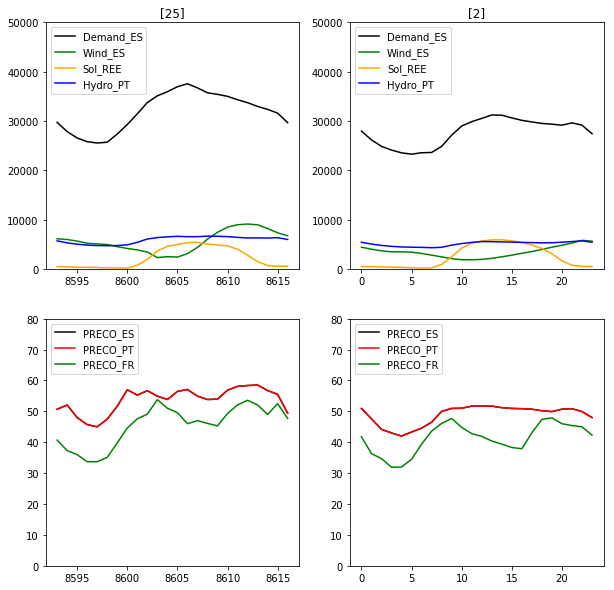

In [60]:
n=24
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.plot(X_train.REE_DEMAND_ES_1fut.tail(n), 'black')
plt.plot(X_train.Wind_ES_1fut.tail(n), 'green')
plt.plot(X_train.Sol_REE_1fut.tail(n), 'orange')
plt.plot(X_train.Hydro_PT_1fut.tail(n), 'blue')
plt.legend(['Demand_ES', 'Wind_ES', 'Sol_REE', 'Hydro_PT'], loc ='upper left')
plt.title(str(X_train.tail(1).day.values))
plt.ylim([0, 50000])
plt.subplot(222)
plt.plot(X_pred.REE_DEMAND_ES_1fut.tail(n), 'black')
plt.plot(X_pred.Wind_ES_1fut.tail(n), 'green')
plt.plot(X_pred.Sol_REE_1fut.tail(n), 'orange')
plt.plot(X_pred.Hydro_PT_1fut.tail(n), 'blue')
plt.legend(['Demand_ES', 'Wind_ES', 'Sol_REE', 'Hydro_PT'], loc ='upper left')
plt.ylim([0, 50000])
plt.title(str(X_pred.tail(1).day.values))

plt.subplot(223)
plt.plot(X_train.PRECO_ES.tail(n), 'black')
plt.plot(X_train.PRECO_PT.tail(n), 'red')
plt.plot(X_train.PRECO_FR_1fut.tail(n), 'green')
plt.legend(['PRECO_ES', 'PRECO_PT', 'PRECO_FR'], loc ='upper left')
plt.ylim([0, 80])

plt.subplot(224)
plt.plot(X_pred.PRECO_ES.tail(n), 'black')
plt.plot(X_pred.PRECO_PT.tail(n), 'red')
plt.plot(X_pred.PRECO_FR.tail(n), 'green')
plt.legend(['PRECO_ES', 'PRECO_PT', 'PRECO_FR'], loc ='upper left')
plt.ylim([0, 80])

plt.savefig('C:/Users/e351722/OneDrive - EDP/REN_prediction/Predictive2/data.png')  # save the figure to file


# Define Models

## XGBOOST Model

In [61]:
# Build XGBoost Model
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def prediction_xgboost_pca(x_train, y_train, x_test, y_test):
    """
    Machine learning implementation - XGBoost algorithm.

    :param x_train: Predictors train.
    :param y_train: Response variable train.
    :param x_test: Predictors test.
    :param y_test: Response variable test.
    :return: The XGBoost model.
    """
    # Define the splits.
    # idxs = np.arange(N)
    cv_splits = 5
    clf = xgb.XGBRegressor(objective="reg:linear")
    # Defining the grid search
    
    
    # ---------------------------------------------------without pca-----------------------------------------------------
#{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0.03, 'gpu_id': 0, 'learning_rate': 0.1,
 #'max_bin': 256, 'n_estimators': 400,'predictor': 'gpu_predictor', 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.8,
 #'tree_method': 'gpu_hist'}
    # --------------------------------------------------with pca-------------------
#{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0.01, 'gpu_id': 0, 'learning_rate': 0.1,
#'max_bin': 256, 'n_estimators': 500, 'predictor': 'gpu_predictor', 'reg_alpha': 0.01,'reg_lambda': 1, 'subsample': 0.8,
#'tree_method': 'gpu_hist'earning_rate': 0.03, 'subsample': 0.8, 'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'max_depth': 15}
    # --------------------------------------------------with pca feat.sel.---------------------------------------------------------
#{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0.01, 'gpu_id': 0, 'learning_rate': 0.1,
# 'max_bin': 256, 'n_estimators': 500, 'predictor': 'gpu_predictor', 'reg_alpha': 0.01,'reg_lambda': 1, 'subsample': 0.8, 
# 'tree_method': 'gpu_hist'}
# --------------------------------------------------.---------------------------------------------------------
    
    
  #  , 'gpu_id':[0], 'max_bin':[16],
  #                'predictor': ['gpu_predictor'], 'tree_method': ['gpu_hist'], 'eval_metric': ['mae']
    
    param_grid = {'colsample_bylevel': [1], 'colsample_bytree': [0.7], 'eval_metric': ['mae'],
                  'gamma': [0.03], 'gpu_id': [0], 'learning_rate': [0.1], 'max_bin': [256],
                  'n_estimators': [400], 'predictor': ['gpu_predictor'], 'reg_alpha': [0.01],
                  'reg_lambda': [1], 'subsample': [0.8], 'tree_method': ['gpu_hist']
    
                  }
    
 #   param_grid = {'colsample_bylevel': [1], 'colsample_bytree': [0.7],
 #                 'gamma': [0.03], 'learning_rate': [0.1],
 #                 'n_estimators': [400], 'reg_alpha': [0.01],
 #                 'reg_lambda': [1], 'subsample': [0.8]
 #  
 #                 }

    print('    Model training')

    tree_grid = GridSearchCV(estimator=clf, param_grid=param_grid,
                             iid=False, refit=True, cv=cv_splits, verbose=5, n_jobs = -1) #, scoring='neg_mean_squared_error'
    tree = tree_grid.fit(x_train, y_train)
    

    print(tree.best_params_)
    tree_predict = tree.predict(x_test)
#    features = tree.estimator.fit(x_train, y_train).feature_importances_
#    feature_imp_df = pd.DataFrame({'Importance': features},
#                                  index=x_test.columns.ravel()).sort_values('Importance', ascending=False)

    #feature_imp_plot(imp_feat)
    #print(features)
    print('\n', 'r2_score:', r2_score(y_test, tree_predict), '\n',
          'mean_squared_error', mean_squared_error(y_test, tree_predict), '\n',
 #         'mean_absolute_error', mean_absolute_error(y_test, tree_predict), '\n',
          'mean_absolute_percentage_error', mean_absolute_percentage_error(y_test, tree_predict), '\n')
    MAP_error = mean_absolute_percentage_error(y_test, tree_predict)
    
    print('\n')
    
#    d7_mean = x_test['PRECO_ES']

#    print('\n', 'r2_score d:', r2_score(y_test, d7_mean), '\n',
#          'mean_squared_error d', mean_squared_error(y_test, d7_mean), '\n',
#         'mean_absolute_error d7 mean', mean_absolute_error(d7_mean, tree_predict), '\n',
#          'mean_absolute_percentage_error d', mean_absolute_percentage_error(y_test, d7_mean), '\n')

    print('\n')
    
    return tree_predict, y_test, tree, MAP_error




## Keras Long Short Term Memory Neural Network

In [62]:
def keras_dnn(x_train, y_train, x_test, y_test):

    '''Using normalized data to predict day ahead prices'''
    import pandas as pd
    #from sklearn.cross_validation import train_test_split
    from IPython import display
    from matplotlib import cm
    from matplotlib import gridspec
    from matplotlib import pyplot as plt
    import numpy as np
    import pandas as pd
    from sklearn import metrics
    import tensorflow as tf
    from tensorflow.python.data import Dataset
    import keras
    from keras.utils import to_categorical
    from keras import models
    from keras import layers
    import math
    import matplotlib.pyplot as plt
    #df = pd.read_csv('covtype.csv')
    from keras.layers import BatchNormalization


    hl_scaling = 4
    input_layer = np.shape(x_train)[1]
    output_layer = 1
    middle_hidden_layer = round((np.shape(x_train)[0])/(hl_scaling*(np.shape(x_train)[1]+output_layer)))

    #x_train, x_test, y_train, y_test = train_test_split(x, y , train_size = 0.7, random_state =  90)
    #'''As y variable is multi class categorical variable, hence using softmax as activation function and sparse-categorical cross entropy as loss function.'''
    model = keras.Sequential([
     keras.layers.BatchNormalization(input_shape=(x_train.shape[1],)),

     keras.layers.Dense(input_layer, kernel_initializer='normal', activation=tf.nn.relu,                  
     input_shape=(x_train.shape[1],)),
     #keras.layers.Dropout(0.8, noise_shape=None, seed=None),
     keras.layers.Dense(middle_hidden_layer,  kernel_initializer='normal', activation=tf.nn.relu),
  #   keras.layers.Dropout(0.8, noise_shape=None, seed=None),
  #   keras.layers.Dense(round(middle_hidden_layer/2),  kernel_initializer='normal', activation=tf.nn.relu),
        
  #   keras.layers.Dense(round(middle_hidden_layer/4),  kernel_initializer='normal', activation=tf.nn.relu),

     keras.layers.Dense(output_layer, activation='linear'),


     #keras.layers.Dense(1, activation=  'softmax')
     ])

    
    model.compile(optimizer='adam',
              loss='mean_absolute_percentage_error',
              metrics=['mean_absolute_percentage_error'])
    history1 = model.fit(
     x_train, y_train,
     epochs= 100, batch_size = 100,
     validation_data = (x_test, y_test))

    return history1, model

#make plots
def plot_history(history1):
 plt.figure()
 plt.xlabel('Epoch')
 plt.ylabel('Mean Absolute Percent Error [1000$]')
 plt.plot(history1.epoch, np.array(history1.history['mean_absolute_percentage_error']),
 label='Train MAPE')
 plt.plot(history1.epoch, np.array(history1.history['val_mean_absolute_percentage_error']),
 label = 'Val MAPE')
 plt.legend()


# Deep Neural Network (Scikit Learn MLPRegressor)

In [63]:
def dnn_prediction_model(list_var):
    """
    Support vector regression algorithm.

    :param list_var: List with the test and train components.
    :return: The SVR model.
    """
    # Unpacking the variables
    x_train_c, y_train, x_test_c, y_test = list_var

    cv_splits = 4
    hl_scaling = 2
    input_layer = np.shape(x_train_c)[1]
    output_layer = 1
    middle_hidden_layer = round((np.shape(x_train_c)[0])/(hl_scaling*(np.shape(x_train_c)[1]+output_layer)))

    # Defining the ML ensemble methods to apply
    clf = MLPRegressor( hidden_layer_sizes=(input_layer,middle_hidden_layer,output_layer),  activation='identity', solver='adam', alpha=0.001, batch_size='auto',
    learning_rate='adaptive', learning_rate_init=0.0005, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=9, tol=0.0001, verbose=True, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
    early_stopping=False, validation_fraction=0.2, beta_1=0.9, beta_2=0.99, epsilon=1e-08)
    

    param_grid = {}
    

    dnn_grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, iid=True,
                            refit=True, cv=cv_splits, scoring='neg_mean_absolute_error')


    dnn_fit = dnn_grid.fit(x_train_c, y_train)
    
    dnn_grid.fit(x_train_c, y_train)

    # Printing the best parameters of the model

    # Predicting the data using the test data
    dnn_predict = dnn_fit.predict(x_test_c)

    #features_NN =     svr_grid.best_estimator_.feature_importances_

    #feature_imp_df_NN = pd.DataFrame({'Importance': features_NN},
    #                              index=x_test.columns.ravel()).sort_values('Importance', ascending=False)

    #feature_imp_plot(imp_feat)
    #print(feature_imp_df_NN)

    # Printing the scores to estimate the quality of the model.
    print('r2_score:', r2_score(y_test, dnn_predict), '\n',
          'mean_squared_error', mean_squared_error(y_test, dnn_predict), '\n',
          'mean_absolute_error', mean_absolute_error(y_test, dnn_predict), '\n',
          'mean_absolute_percentage_error', mean_absolute_percentage_error(y_test, dnn_predict), '\n')
    print('best parameters: ', dnn_fit.best_params_)

    print('\n')

    def metric_model_plot_dnn(y_test_c_f, dnn_predict_f):

        max_x = max(dnn_predict_f)
        min_x = min(dnn_predict_f)
        plt.figure()
        plt.scatter(y_test_c_f, dnn_predict_f, c="darkorange", label="data")
        plt.plot([min_x, max_x], [min_x, max_x], 'k--')
        plt.xlabel("Actual values")
        plt.ylabel("Predicted values")
        plt.title("Decision Tree")
        plt.legend()
        #plt.savefig('fig_svm.png')
        plt.show()
        return None

    #metric_model_plot_dnn(y_test, dnn_predict)
    return dnn_fit


# Linear Model (lasso regularization)

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV


from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    prediction = model.predict(X_test)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');


# Train Models

In [65]:
# XGBoost
from sklearn.metrics import r2_score, mean_squared_error,  mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
predicted1, y_test1, tree1, MAP_error1 = prediction_xgboost_pca(X_train_exp, y_train, X_test_exp, y_test)
# Generate Day-ahead prediction
prediction1 = list(tree1.predict(X_pred_exp))
testpred1 = list(tree1.predict(X_test_exp))
model1 = tree1    

# Lasso
lasso = LassoCV(cv=tscv)
lasso.fit(x_train_c_exp, y_train)
prediction2 = lasso.predict(x_pred_c_exp)
testpred2 = lasso.predict(x_test_c_exp)
model2 = lasso       


# Random Forest 
# `outer_cv` creates 4 folds for estimating generalization error
outer_cv = KFold(4)

# when we train on a certain fold, we use a second cross-validation
# split in order to choose hyperparameters
inner_cv = KFold(4)

# create some regression data
X, y = X_train_exp, y_train
# give shorthand names to models and use those as dictionary keys mapping
# to models and parameter grids for that model
models_and_parameters = {
    'rf_9': (RandomForestRegressor(),
             {'max_depth': [9]}),
    'rf_15': (RandomForestRegressor(),
              {'max_depth': [15]}),
}
#    'svr': (SVR(),
#            {'C': [0.01]}),
# 
#    'dnn': (MLPRegressor( hidden_layer_sizes=(50,25,10),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
#            learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
#            random_state=0, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
#            early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)),
# we will collect the average of the scores on the 3 outer folds in this dictionary
# with keys given by the names of the models in `models_and_parameters`
average_scores_across_outer_folds_for_each_model = dict()
# find the model with the best generalization error
for name, (model, params) in models_and_parameters.items():
    # this object is a regressor that also happens to choose
    # its hyperparameters automatically using `inner_cv`
    regressor_that_optimizes_its_hyperparams = GridSearchCV(
        estimator=model, param_grid=params,
        cv=inner_cv, scoring='neg_mean_squared_error')
    # estimate generalization error on the 3-fold splits of the data
    scores_across_outer_folds = cross_val_score(
        regressor_that_optimizes_its_hyperparams,
        X, y, cv=outer_cv, scoring='neg_mean_squared_error')
    # get the mean MSE across each of outer_cv's 3 folds
    average_scores_across_outer_folds_for_each_model[name] = np.mean(scores_across_outer_folds)
    error_summary = 'Model: {name}\nMSE in the 3 outer folds: {scores}.\nAverage error: {avg}'
    print(error_summary.format(
        name=name, scores=scores_across_outer_folds,
        avg=np.mean(scores_across_outer_folds)))
    print()
    
print('Average score across the outer folds: ',
average_scores_across_outer_folds_for_each_model)
many_stars = '\n' + '*' * 100 + '\n'
print(many_stars + 'Now we choose the best model and refit on the whole dataset' + many_stars)
best_model_name, best_model_avg_score = max(
    average_scores_across_outer_folds_for_each_model.items(),
    key=(lambda name_averagescore: name_averagescore[1]))
# get the best model and its associated parameter grid
best_model, best_model_params = models_and_parameters[best_model_name]
# now we refit this best model on the whole dataset so that we can start
# making predictions on other data, and now we have a reliable estimate of
# this model's generalization error and we are confident this is the best model
# among the ones we have tried
final_regressor = GridSearchCV(best_model, best_model_params, cv=inner_cv)
final_regressor.fit(X, y)
print('Best model: \n\t{}'.format(best_model), end='\n\n')
print('Estimation of its generalization error (negative mean squared error):\n\t{}'.format(
    best_model_avg_score), end='\n\n')
print('Best parameter choice for this model: \n\t{params}'
      '\n(according to cross-validation `{cv}` on the whole dataset).'.format(
          params=final_regressor.best_params_, cv=inner_cv))
prediction3 = list(final_regressor.predict(X_pred_exp))
testpred3 = list(final_regressor.predict(X_test_exp))
model3 = final_regressor
            
            
# MLP Regressor
model_dl = dnn_prediction_model([x_train_c_exp, y_train, x_test_c_exp, y_test])
# Back-testing error and Day Ahead Prediction
prediction4 = list(model_dl.predict(x_pred_c_exp))
testpred4 = list(model_dl.predict(x_test_c_exp))
model4 = model_dl        

# Keras LSTM
[history1, model] = keras_dnn(X_train_exp, y_train, X_test_exp, y_test)
# Plot Back-testing prediction
prediction5 = model.predict(X_pred_exp).flatten()
testpred5 = model.predict(X_test_exp).flatten()
model5 = model
def predict(qc):
    global model5
    qc = model5.predict(qc)
    return qc.reshape(qc.shape[0])

    Model training
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.8s remaining:   35.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.0s finished


{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0.03, 'gpu_id': 0, 'learning_rate': 0.1, 'max_bin': 256, 'n_estimators': 400, 'predictor': 'gpu_predictor', 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.8, 'tree_method': 'gpu_hist'}

 r2_score: -0.16271009518429813 
 mean_squared_error 23.88639803210854 
 mean_absolute_percentage_error 9.063744542292344 







C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 

Model: rf_9
MSE in the 3 outer folds: [-24.0780298  -13.39928371 -35.06222028 -57.23551544].
Average error: -32.4437623099722



C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 

Model: rf_15
MSE in the 3 outer folds: [-22.80142839 -12.72781774 -33.60189299 -47.85559733].
Average error: -29.246684112455213

Average score across the outer folds:  {'rf_9': -32.4437623099722, 'rf_15': -29.246684112455213}

****************************************************************************************************
Now we choose the best model and refit on the whole dataset
****************************************************************************************************



C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 

Best model: 
	RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Estimation of its generalization error (negative mean squared error):
	-29.246684112455213

Best parameter choice for this model: 
	{'max_depth': 15}
(according to cross-validation `KFold(n_splits=4, random_state=None, shuffle=False)` on the whole dataset).
Iteration 1, loss = 1694.87879161
Iteration 2, loss = 1617.50987792
Iteration 3, loss = 1497.79049873
Iteration 4, loss = 1287.82524984
Iteration 5, loss = 976.73543644
Iteration 6, loss = 604.65273631
Iteration 7, loss = 274.34845739
Iteration 8, loss = 71.85884469
Iteration 9, loss = 12.92950749
Iteration 10, loss = 7.51790424
Iterat

8617/8617 [==============================] - 0s 36us/step - loss: 4.3086 - mean_absolute_percentage_error: 4.3086 - val_loss: 8.1709 - val_mean_absolute_percentage_error: 8.1709
Epoch 26/100
8617/8617 [==============================] - 0s 36us/step - loss: 3.9708 - mean_absolute_percentage_error: 3.9708 - val_loss: 9.3337 - val_mean_absolute_percentage_error: 9.3337
Epoch 27/100
8617/8617 [==============================] - 0s 36us/step - loss: 3.8993 - mean_absolute_percentage_error: 3.8993 - val_loss: 7.7791 - val_mean_absolute_percentage_error: 7.7791
Epoch 28/100
8617/8617 [==============================] - 0s 36us/step - loss: 3.9301 - mean_absolute_percentage_error: 3.9301 - val_loss: 9.9550 - val_mean_absolute_percentage_error: 9.9550
Epoch 29/100
8617/8617 [==============================] - 0s 36us/step - loss: 3.9001 - mean_absolute_percentage_error: 3.9001 - val_loss: 9.6480 - val_mean_absolute_percentage_error: 9.6480
Epoch 30/100
8617/8617 [==============================] - 

Epoch 68/100
8617/8617 [==============================] - 0s 36us/step - loss: 3.4360 - mean_absolute_percentage_error: 3.4360 - val_loss: 10.0525 - val_mean_absolute_percentage_error: 10.0525
Epoch 69/100
8617/8617 [==============================] - 0s 36us/step - loss: 3.3458 - mean_absolute_percentage_error: 3.3458 - val_loss: 9.7377 - val_mean_absolute_percentage_error: 9.7377
Epoch 70/100
8617/8617 [==============================] - 0s 36us/step - loss: 3.2884 - mean_absolute_percentage_error: 3.2884 - val_loss: 9.0309 - val_mean_absolute_percentage_error: 9.0309
Epoch 71/100
8617/8617 [==============================] - 0s 36us/step - loss: 3.4639 - mean_absolute_percentage_error: 3.4639 - val_loss: 8.6762 - val_mean_absolute_percentage_error: 8.6762
Epoch 72/100
8617/8617 [==============================] - 0s 36us/step - loss: 3.2812 - mean_absolute_percentage_error: 3.2812 - val_loss: 8.9142 - val_mean_absolute_percentage_error: 8.9142
Epoch 73/100
8617/8617 [===================

In [66]:
features = tree1.estimator.fit(X_train, y_train).feature_importances_
feature_imp_df = pd.DataFrame({'Importance': features},
                                  index=X_test.columns.ravel()).sort_values('Importance', ascending=False)

In [67]:
feature_imp_df.head(20)

,Importance
Energy_Gap_1fut,0.105036
Wind_ES_1fut,0.103597
PRECO_FR_1fut,0.060432
Hydro_PT_1fut,0.037410
"(Q, NATVD12)",0.024460
PRECO_ES_144,0.024460
REE_DEMAND_ES_1fut,0.017266
"(P, SINES1)",0.017266
"(P, ACAVADB)",0.015827
"(P, GUADIAB)",0.015827


# Save Predictions

In [68]:
# Save model predictions to xls

models_output = np.array([list(prediction1), 
                                list(prediction2), 
                                list(prediction3), 
                                list(prediction4),
                                list(prediction5),

                                 ])

model_names = np.array(['XGB', 'Lasso', 'RF', 'DNN', 'LSTM'])


import csv 
import datetime
now = datetime.datetime.now()

prediction_date_vector = pred_date_END+timedelta(2)
prediction_date_vector = prediction_date_vector.strftime('%Y-%m-%d')

DATA = pd.DataFrame([prediction_date_vector]*24, columns = ['DATA'])

HOURS = pd.DataFrame(list(range(1,25)), columns = ['Hour'])

csvfile_top = pd.DataFrame(models_output[:,].mean(axis=0), columns = ['Mean'])


csvfile_1 = pd.DataFrame(list(prediction1), columns = ['XGB'])

csvfile_2 = pd.DataFrame(list(prediction2), columns = ['Lasso'])

csvfile_3= pd.DataFrame(list(prediction3), columns = ['RF'])

csvfile_4 = pd.DataFrame(list(prediction4), columns = ['DNN'])

csvfile_5 = pd.DataFrame(list(prediction5), columns = ['LSTM'])

cvfileall = pd.concat([DATA, HOURS, csvfile_top, csvfile_1, csvfile_2, csvfile_3, csvfile_4, csvfile_5], axis = 1)

test_date = pred_date_END+timedelta(1)
test_date = test_date.strftime('%Y%m%d')

prediction_date = pred_date_END+timedelta(2)
prediction_date = prediction_date.strftime('%Y%m%d')

cvfileall.to_excel('C:/Users/e351722/OneDrive - EDP/REN_prediction/results/InterpretableCV7_'+prediction_date+'.xlsx', sheet_name='sheet1', index=False)

# Test-Set

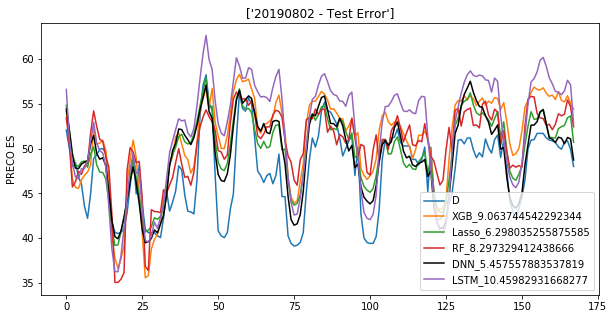

In [69]:
model_test_preds = np.array([list(testpred1),
                             list(testpred2),
                             list(testpred3),
                             list(testpred4),
                             list(testpred5), 
])

models_test_mapes=[]
for ind in range(0,np.shape(model_test_preds)[0]):
    models_test_mapes.append(mean_absolute_percentage_error(y_test, model_test_preds[ind,:]))

minTestIndex = np.argmin(models_test_mapes)


plt.figure(figsize=(10,5))
plt.plot(y_test, label= 'D')
for index in range(0,5):
    if index == minTestIndex:
        plt.plot(model_test_preds[index], label= model_names[index]+'_'+str(models_test_mapes[index]), color = 'black')
    else: 
        plt.plot(model_test_preds[index], label= model_names[index]+'_'+str(models_test_mapes[index]))

#plt.plot(predictedkieras, label= model_names[5]+'_'+str(models_list[5]))

    plt.legend()

    plt.title([str(test_date) + ' - Test Error'])

    plt.ylabel('PRECO ES')

plt.savefig('C:/Users/e351722/OneDrive - EDP/REN_prediction/InterpretableML/TestCV7.png')  # save the figure to file


# Select model with best back-tested results

C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


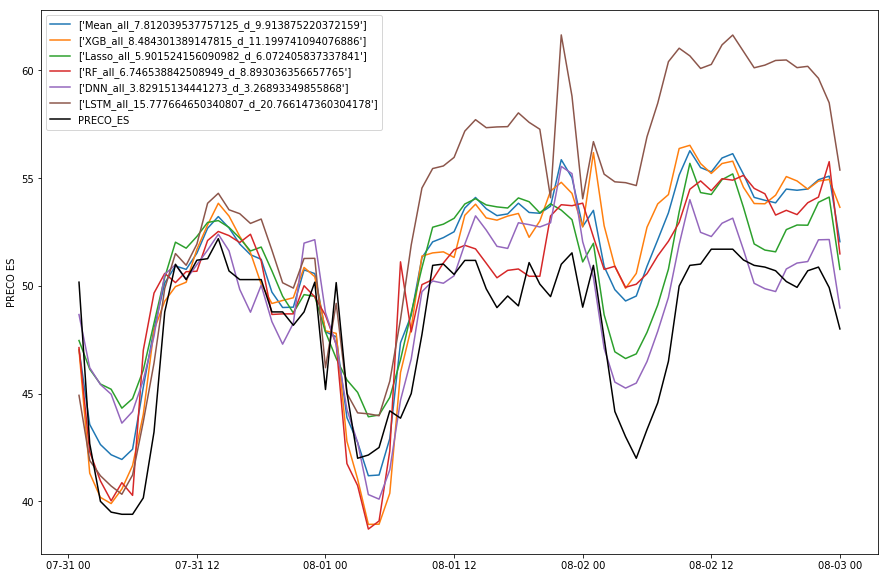

In [70]:
from os import listdir
from os.path import isfile, join
import re

mypath = 'C:/Users/e351722/OneDrive - EDP/REN_prediction/results'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

onlyfiles

forecastCV_model =  pd.DataFrame(index = range(0, len(onlyfiles)), columns = ['InterpretableML_'], dtype='float')
for ind in range(0,len(onlyfiles)):
    if re.match(r'InterpretableML_+', onlyfiles[ind]):
        forecastCV_model.InterpretableML_[ind] = 1
    else:
        forecastCV_model.InterpretableML_[ind] = 0
nfiles = sum(forecastCV_model.InterpretableML_)

dfbt = pd.DataFrame()
for ind in range(0, len(forecastCV_model)):
    if forecastCV_model.InterpretableML_[ind]:
        dfint = pd.read_excel(mypath+'/'+onlyfiles[ind], sheet_name='sheet1')
        dfint = dfint.dropna()
        dfbt= dfbt.append(dfint)
dfbt = dfbt.reset_index(drop=True)

dfbt.DATA = pd.DatetimeIndex(dfbt.DATA)
unique_dates = dfbt.DATA.unique()

dfbt= dfbt[dfbt['DATA'] <= max(df1['DATA'])]

df_actual = deepcopy(df1)

df_actual = df_actual[df_actual.DATA.isin(unique_dates)].reset_index(drop = True)

for ind in range(0, len(df_actual)):
    df_actual.DATA[ind] = df_actual.DATA[ind] + timedelta(hours = int(df_actual.HORA[ind]))

for ind in range(0, len(dfbt)):
    dfbt.DATA[ind] = dfbt.DATA[ind] + timedelta(hours = int(dfbt.Hour[ind]))
    
fig, ax = plt.subplots(figsize=(15, 10))

mapes = np.empty([np.shape(dfbt.columns.drop(['DATA', 'Hour']))[0]-1])
ind = 0
for column in dfbt.columns.drop(['DATA', 'Hour']):
        plt.plot(dfbt.DATA, dfbt[column], label= [column+'_all_'+
                                                str(mean_absolute_percentage_error(df_actual.PRECO_ES.tail(48), dfbt[column].tail(48)))+ '_d_'+
                                                str(mean_absolute_percentage_error(df_actual.PRECO_ES.tail(24), dfbt[column].tail(24)))
                                               ])
        if ind > 0:
            mapes[ind-1] = mean_absolute_percentage_error(df_actual.PRECO_ES.tail(24), dfbt[column].tail(24))
        ind = ind+1

#for column in dfbt.columns.drop(['DATA', 'Hour']):
#        plt.plot(dfbt.DATA, dfbt[column], label= [column+'_'+str(mean_absolute_percentage_error(df_actual.PRECO_ES, dfbt[column]))])


#plt.plot(predictedkieras, label= model_names[5]+'_'+str(models_list[5]))
plt.plot(df_actual.DATA, df_actual.PRECO_ES, 'black')

plt.legend()

#plt.title([str(test_date) + ' - Date of Prediction for Tomorrow'])

plt.ylabel('PRECO ES')
plt.savefig('C:/Users/e351722/OneDrive - EDP/REN_prediction/Predictive2/Backtest_InterpretableML_.png')  # save the figure to file

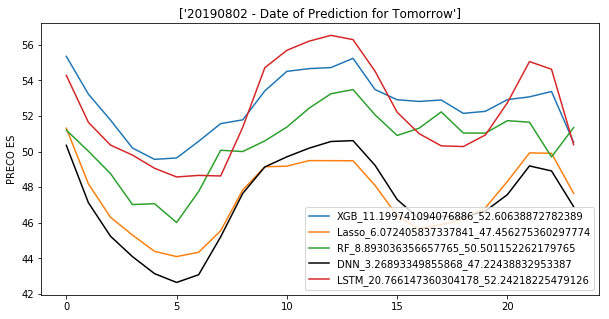

In [71]:
plt.figure(figsize=(10,5))
#plt.plot(y_test, label= 'D')
minIndex = np.argmin(mapes)

for index in range(0,5):
    if index == minIndex:
        plt.plot(models_output[index], label= model_names[index]+'_'+str(mapes[index])+'_'+str(np.mean(models_output[index])), color = 'black')
    else: 
        plt.plot(models_output[index], label= model_names[index]+'_'+str(mapes[index])+'_'+str(np.mean(models_output[index])))

#plt.plot(predictedkieras, label= model_names[5]+'_'+str(models_list[5]))

    plt.legend()

    plt.title([str(test_date) + ' - Date of Prediction for Tomorrow'])

    plt.ylabel('PRECO ES')

plt.savefig('C:/Users/e351722/OneDrive - EDP/REN_prediction/InterpretableML/AllModels_cv7'+ '.png')  # save the figure to file


#http://www.tweepy.org/
import tweepy


#@Modelo-XGB
#Get your Twitter API credentials and enter them here
consumer_key = "O8tCwBAPCNaGxtXAtxPiw29pl"
consumer_secret = 'W4uQQTqmHb64oPXddmNu8wNotNROJcegSTlNGiaWQX2PguHAhP'
access_key = "1112641085740933121-VnqKkHzAuTsUma4ARVL3kJF0TGgU6r"
access_secret = "qxZEQ8XpFxt2SnyWwz0JulsF8cHWWBUQxozi0ES9pHmBy"


#authorize twitter, initialize tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

#user = api.me()

tomorrow_pred = np.mean(models_output[minIndex])
phrase = str(np.round(tomorrow_pred*100)/100)

api.update_status("#" + 'porrapool' + " " + phrase)

In [72]:
if minIndex == 0:
    tomorrow_forecast = prediction1
    tomorrow_model = model1
if minIndex == 1:
    tomorrow_forecast = prediction2
    tomorrow_model = model2
if minIndex == 2:
    tomorrow_forecast = prediction3
    tomorrow_model = model3
if minIndex == 3:
    tomorrow_forecast = prediction4
    tomorrow_model = model4
if minIndex == 4:
    tomorrow_forecast = prediction5
    tomorrow_model = model5




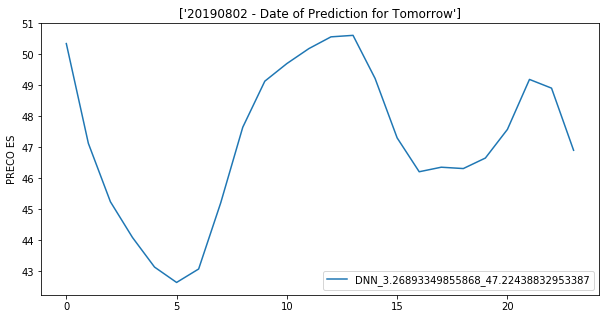

In [73]:
plt.figure(figsize=(10,5))


plt.plot(tomorrow_forecast, label= model_names[minIndex]+'_'+str(mapes[minIndex])+'_'+str(np.mean(tomorrow_forecast)))

#plt.plot(predictedkieras, label= model_names[5]+'_'+str(models_list[5]))

plt.legend()

plt.title([str(test_date) + ' - Date of Prediction for Tomorrow'])

plt.ylabel('PRECO ES')
plt.savefig('C:/Users/e351722/OneDrive - EDP/REN_prediction/Predictive2/BestModel'+'.png')  # save the figure to file

In [74]:

if (minIndex==0) | (minIndex==2)  | (minIndex ==4):
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train_exp, feature_names=labels, class_names=['Compras_concurrenca'], verbose=True, mode='regression')

if (minIndex == 1) | (minIndex==3):
    explainer = lime.lime_tabular.LimeTabularExplainer(x_train_c_exp, feature_names=labels, class_names=['Compras_concurrenca'], verbose=True, mode='regression')


index_min = np.argmin(tomorrow_forecast)
index_max = np.argmax(tomorrow_forecast)


In [75]:
# Which Hour do you want to Explain?
i = index_max
if minIndex == 4:
    exp = explainer.explain_instance(X_pred_exp[i], predict, num_features=4, top_labels=1 )
if (minIndex==0) | (minIndex==2):
    exp = explainer.explain_instance(X_pred_exp[i], tomorrow_model.predict, num_features=4, top_labels=1 )
if (minIndex == 1) | (minIndex==3):
    exp = explainer.explain_instance(x_pred_c_exp[i], tomorrow_model.predict, num_features=4, top_labels=1 )

    
print('Hour ' + str(i))

#exp.show_in_notebook(show_table=True, show_all=False
#                    )

Intercept 58.08048164853179
Prediction_local [54.74550141]
Right: 50.61155975052468
Hour 13


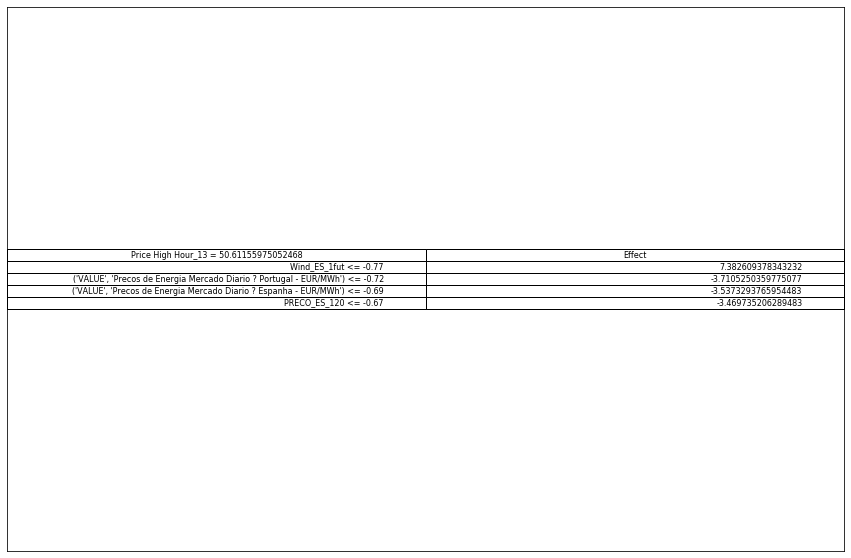

In [76]:
# Which Hour do you want to Explain?
low = pd.DataFrame({'Price High Hour_'+str(index_max)+' = '+str(tomorrow_forecast[index_max]):pd.DataFrame(exp.as_list())[0], 'Effect':pd.DataFrame(exp.as_list())[1]}
                   )

import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table 
plt.figure(figsize=(15,10))
ax = plt.subplot(111, frame_on=True) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, low, loc='center', rowLabels=['']*low.shape[0])  # where df is your data frame

#plt.savefig('C:/Users/e351722/OneDrive - EDP/REN_prediction/Predictive/Descriptive_'+'highHour.png')

In [77]:
cm = sns.diverging_palette(10,250, as_cmap=True)

s = low.style.background_gradient(cmap=cm, high=0, low=.1, axis=0)
html1 = s.hide_index().render()

s

Price High Hour_13 = 50.61155975052468,Effect
Wind_ES_1fut <= -0.77,7.38261
"('VALUE', 'Precos de Energia Mercado Diario ? Portugal - EUR/MWh') <= -0.72",-3.71053
"('VALUE', 'Precos de Energia Mercado Diario ? Espanha - EUR/MWh') <= -0.69",-3.53733
PRECO_ES_120 <= -0.67,-3.46974


In [78]:
# Which Hour do you want to Explain?
i = index_min
if minIndex == 4:
    exp = explainer.explain_instance(X_pred_exp[i], predict, num_features=4, top_labels=1 )
if (minIndex==0) | (minIndex==2):
    exp = explainer.explain_instance(X_pred_exp[i], tomorrow_model.predict, num_features=4, top_labels=1 )
if (minIndex == 1) | (minIndex==3):
    exp = explainer.explain_instance(x_pred_c_exp[i], tomorrow_model.predict, num_features=4, top_labels=1 )
    
print('Hour ' + str(i))

#exp.show_in_notebook(show_table=True, show_all=False
#                    )

Intercept 58.701079041708056
Prediction_local [53.00127449]
Right: 42.64402468999356
Hour 5


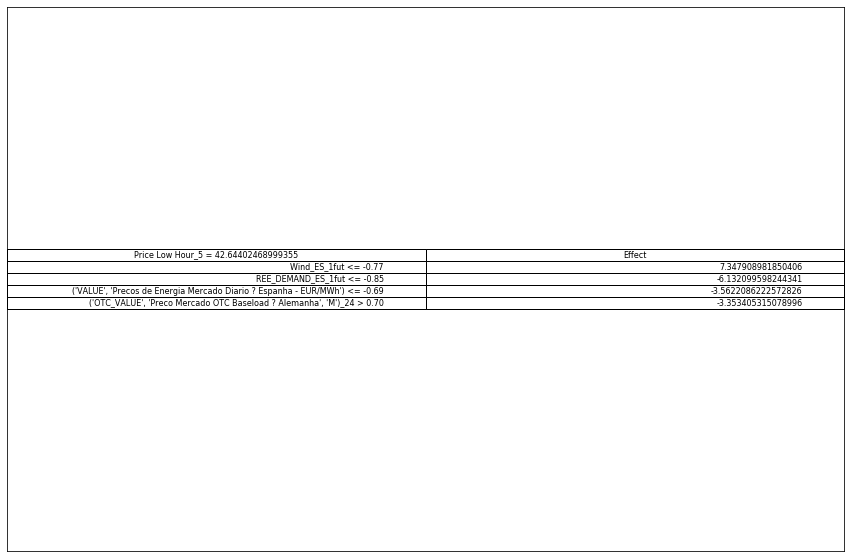

In [79]:
# Which Hour do you want to Explain?
low = pd.DataFrame({'Price Low Hour_'+str(index_min)+' = '+str(tomorrow_forecast[index_min]):pd.DataFrame(exp.as_list())[0], 'Effect':pd.DataFrame(exp.as_list())[1]}
                   )


import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table 
plt.figure(figsize=(15,10))
ax = plt.subplot(111, frame_on=True) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, low, loc='center', rowLabels=['']*low.shape[0])  # where df is your data frame

#plt.savefig('C:/Users/e351722/OneDrive - EDP/REN_prediction/Predictive/Descriptive_'+'lowHour.png')

In [80]:
cm = sns.diverging_palette(10,250, as_cmap=True)

s = low.style.background_gradient(cmap=cm, high=0, low=.1, axis=0)
html2 = s.hide_index().render()

s

Price Low Hour_5 = 42.64402468999355,Effect
Wind_ES_1fut <= -0.77,7.34791
REE_DEMAND_ES_1fut <= -0.85,-6.1321
"('VALUE', 'Precos de Energia Mercado Diario ? Espanha - EUR/MWh') <= -0.69",-3.56221
"('OTC_VALUE', 'Preco Mercado OTC Baseload ? Alemanha', 'M')_24 > 0.70",-3.35341


html0 =   '<img src=\'C:/Users/e351722/OneDrive - EDP/REN_prediction/Predictive2/AllModels'+ '.png\'>' 

html3 = '<img src=\'C:/Users/e351722/OneDrive - EDP/REN_prediction/Predictive2/data'+ '.png\'>' 


html_head = """<!DOCTYPE html>
<html>
<head>
<style>
* {
  box-sizing: border-box;
}

.column {
  float: left;
  width: 20%;
  padding: 5px;
}

/* Clearfix (clear floats) */
.row::after {
  content: "";
  clear: both;
  display: table;
}
</style>
</head>
<body>

<h2>D+1 PRECO_ES Forecast</h2>
<p>Winning prediction for last 2 days in black.</p>"""

with open('C:/Users/e351722/OneDrive - EDP/REN_prediction/Predictive2/PredictionsDashboard.html','w') as f:
    f.write(html_head)
    f.write("""</div> <div class="row">""")
    f.write("""</div> <div class="row">""")
    f.write(html0)
    f.write("""</div> <div class="row">""")
    f.write("""</div> <div class="row">""")
    f.write("""<p>Explanations</p>""")
    f.write("""</div> <div class="column">""")
    f.write(html2)
    f.write("""</div> <div class="column">""")
    f.write(html1)
    f.write("""</div> <div class="row">""")
    f.write("""</div> <div class="row">""")
    f.write("""<p>Data Inputs</p>""")
    f.write(html3)
